In [101]:
import sys
import numpy as np
import pandas as pd
from scipy.io import loadmat
import matplotlib.pyplot as plt

from pathlib import Path
import torch

from pipeline_vsdi import cleaning as cl
from pipeline_vsdi.embedding import VAE

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import DataLoader, random_split

from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from random import shuffle


# import VAE_Dante as VAE
# from vsdi import DataLoader
# from vsdi_preprocessing import clean_outliers
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
# from scipy.signal import savgol_filter
# from scipy.ndimage import gaussian_filter1d
# from scipy.interpolate import interp1d
import torch.optim as optim
from torchvision.transforms import transforms
import torch.optim.lr_scheduler as lr_scheduler


# from sklearn.linear_model import LogisticRegression
# import matplotlib.pyplot as plt


In [79]:
# PATHS AND PARAMETERS
DATA_PATH = Path('/Volumes/imaging1/davide/ATC_Data_preprocessed')
OUTPUT_BASE_PATH = Path('/Users/davide/Dropbox/Projects/ATC/autoencoders')

MODEL_PATH = OUTPUT_BASE_PATH.joinpath('models')

# Initialize variables
animals = ['A04', 'A06', 'A07', 'A08']
days = ['Day1','Day3','Day5','Day7']


BATCH_SIZE = 256
N_EPOCHS = 5
LEARNING_RATE = pow(10,-4)

LATENT_DIM = 10


criterion = nn.MSELoss()


In [ ]:
for animal,day in product(animals,days):

    print(f'TRAINING AUTOENCODER FOR ANIMAL: {animal}, DAY {day}')


    # load data
    vsdi1 = loadmat(DATA_PATH.joinpath(f'{animal}/{day}/vsdi_ATC1.mat'))['vsdi_data']
    vsdi2 = loadmat(DATA_PATH.joinpath(f'{animal}/{day}/vsdi_ATC2.mat'))['vsdi_data']
    mask = loadmat(DATA_PATH.joinpath(f'{animal}/{day}/vsdi_mask.mat'))['mask']

    # prepare data
    vsdi = np.concatenate([vsdi1,vsdi2],axis=-1)

    # concatenate sessions

    X = cl.clean_outliers(vsdi)
    # reshape in (n_sapmples,n_channels,n_pixels,n_pixels) format
    X = np.transpose(X,(2,0,1))
    X = X[:,np.newaxis,:,:]
    # scale each imahe independently betw. 0 and 1
    d = np.max(X,axis=(1,2,3))[:, np.newaxis, np.newaxis, np.newaxis] - np.min(X,axis=(1,2,3))[:, np.newaxis, np.newaxis, np.newaxis]
    X = (X - np.min(X,axis=(1,2,3))[:, np.newaxis, np.newaxis, np.newaxis]) / d

    train_size = 80*X.shape[0]//100
    valid_size = X.shape[0] - train_size
    train, valid = random_split(X,[train_size,valid_size])
    trainloader = DataLoader(train, batch_size=BATCH_SIZE)
    validloader = DataLoader(valid, batch_size=BATCH_SIZE)

    h = X.shape[-1]
    w = X.shape[-2]
    
    # model definition and compliation
    model = Conv_AE(LATENT_DIM,h_pixels=h,w_pixels=w)
    optimizer = optim.Adam(model.parameters(), lr=pow(10,-4), weight_decay=0)

    history = train_autoencoder(model,trainloader,
                            validloader=validloader,
                            epochs = EPOCHS)
    
    if save_history:
        history_path = MODEL_PATH.joinpath(f'history_{animal}_day.pickle')
        with open(history_path, "wb") as file:
            pickle.dump(history, file)


    if save_model:
        torch.save(model,MODEL_PATH.joinpath(f'animal_{animal}_day{day}'))

    
        


    



In [12]:
animal = animals[0]
day = days[0]
vsdi1 = loadmat(DATA_PATH.joinpath(f'{animal}/{day}/vsdi_ATC1.mat'))['vsdi_data']
vsdi2 = loadmat(DATA_PATH.joinpath(f'{animal}/{day}/vsdi_ATC2.mat'))['vsdi_data']
mask = loadmat(DATA_PATH.joinpath(f'{animal}/{day}/vsdi_mask.mat'))['mask']

In [127]:
# clean outliers
X = cl.clean_outliers(vsdi1)
# reshape in (n_sapmples,n_channels,n_pixels,n_pixels) format
X = np.transpose(X,(2,0,1))
X = X[:,np.newaxis,:,:]
# scale each imahe independently betw. 0 and 1
d = np.max(X,axis=(1,2,3))[:, np.newaxis, np.newaxis, np.newaxis] - np.min(X,axis=(1,2,3))[:, np.newaxis, np.newaxis, np.newaxis]
X = (X - np.min(X,axis=(1,2,3))[:, np.newaxis, np.newaxis, np.newaxis]) / d
#X = X[:1]

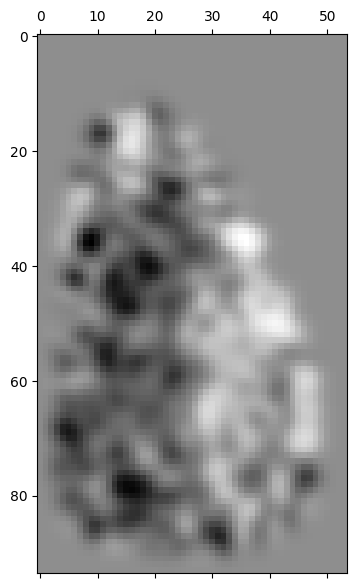

In [64]:
i=11
plt.matshow(X[i,0,:],cmap=plt.cm.Greys)

In [128]:
BATCH_SIZE = 128
N_EPOCHS = 50
LEARNING_RATE = pow(10,-4)

LATENT_DIM = 10
h = X.shape[-1]
w = X.shape[-2]

In [135]:
train_size = 80*X.shape[0]//100
valid_size = X.shape[0] - train_size
train, valid = random_split(X,[train_size,valid_size])
trainloader = DataLoader(train, batch_size=BATCH_SIZE)
validloader = DataLoader(valid, batch_size=BATCH_SIZE)

In [154]:
model = Conv_AE(LATENT_DIM,h_pixels=h,w_pixels=w)
optimizer = optim.Adam(model.parameters(), lr=pow(10,-4), weight_decay=0)
criterion = nn.MSELoss()

# Training loop

In [153]:
def train_autoencoder(model,trainloader,validloader=None,
                      epochs = 5,criterion=nn.MSELoss(),
                      optimizer = None, lr = pow(10,-4),
                      weight_decay = 0,
                      early_stopping = False):

    if optimizer is None:
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    train_history = []
    valid_history = []

    for e in range(epochs):
        train_loss = 0.0
        model.train()  # set model in train mode
        with tqdm(total=len(trainloader)) as pbar:
            for x in trainloader:
                if torch.cuda.is_available():
                    x = x.cuda()
                
                optimizer.zero_grad()
                target = model(x)
                loss = criterion(target,x)
                loss.backward()
                optimizer.step()
                batch_loss = loss.item()
                train_loss += batch_loss
                train_history.append(batch_loss)

                pbar.update(1)
                pbar.set_description(f"Epoch {e+1}/{epochs}, batch loss: {batch_loss:.4f}")
                
        # if validation loader is provided, use it at end of epoch
        if validloader is not None:
            valid_loss = 0.0
            model.eval()     # Optional when not using Model Specific layer
            for x in validloader:
                if torch.cuda.is_available():
                    x = x.cuda()
                
                target = model(x)
                loss = criterion(target,x)
                valid_loss = loss.item() * x.size(0)

            valid_history.append(valid_loss / len(validloader))
            
            print(f'Epoch {e+1} \t\t Training Loss: {train_loss / len(trainloader)} \t\t Validation Loss: {valid_loss / len(validloader)}')
        
        if e>1 and early_stopping:
            if valid_history[-2] < valid_history[-1] :
                print(f'Validation increased({valid_history[-2]:.6f}--->{valid_history[-2]:.6f}) \t stopping training')
                break
    
    return {'train_history':np.asarray(train_history),'validation_history':np.asarray(valid_history)}



In [157]:
history = train_autoencoder(model,trainloader,
                            validloader=validloader,
                            epochs = 1)



Epoch 1/1, batch loss: 0.0100: 100%|██████████| 188/188 [05:41<00:00,  1.82s/it]


Epoch 1 		 Training Loss: 0.011908984520135725 		 Validation Loss: 0.02395261507085029


In [137]:
import numpy as np
epochs = 50
min_valid_loss = np.inf

train_history = []
valid_history = []

for e in range(epochs):
    train_loss = 0.0
    model.train()     # Optional when not using Model Specific layer
    with tqdm(total=len(trainloader)) as pbar:
        for x in trainloader:
            if torch.cuda.is_available():
                x = x.cuda()
            
            optimizer.zero_grad()
            target = model(x)
            loss = criterion(target,x)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            pbar.update(1)
            pbar.set_description(f"Epoch {e+1}/{epochs}, batch loss: {loss.item():.4f}")
    
    train_history.append(train_loss / len(trainloader))
    
    valid_loss = 0.0
    model.eval()     # Optional when not using Model Specific layer
    for x in validloader:
        if torch.cuda.is_available():
            x = x.cuda()
        
        target = model(x)
        loss = criterion(target,x)
        valid_loss = loss.item() * x.size(0)

    valid_history.append(valid_loss / len(validloader))

    print(f'Epoch {e+1} \t\t Training Loss: {train_loss / len(trainloader)} \t\t Validation Loss: {valid_loss / len(validloader)}')

    

    
    # if min_valid_loss > valid_loss:
    #     print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
    #     min_valid_loss = valid_loss
    #     # Saving State Dict
    #     torch.save(model.state_dict(), 'saved_model.pth')

Epoch 1/50, batch loss: 0.0141: 100%|██████████| 188/188 [05:09<00:00,  1.64s/it]


Epoch 1 		 Training Loss: 0.02180385096692183 		 Validation Loss: 0.033459470944201694


Epoch 2/50, batch loss: 0.0089: 100%|██████████| 188/188 [05:06<00:00,  1.63s/it]


Epoch 2 		 Training Loss: 0.010858615979235223 		 Validation Loss: 0.02160659432411194


Epoch 3/50, batch loss: 0.0080: 100%|██████████| 188/188 [05:21<00:00,  1.71s/it]


Epoch 3 		 Training Loss: 0.008622447880817221 		 Validation Loss: 0.019748617994024397


Epoch 4/50, batch loss: 0.0077: 100%|██████████| 188/188 [05:08<00:00,  1.64s/it]


Epoch 4 		 Training Loss: 0.008109046772934813 		 Validation Loss: 0.018859974881435964


Epoch 5/50, batch loss: 0.0076: 100%|██████████| 188/188 [05:05<00:00,  1.63s/it]


Epoch 5 		 Training Loss: 0.007930202578055733 		 Validation Loss: 0.01849061425061936


Epoch 6/50, batch loss: 0.0075: 100%|██████████| 188/188 [05:13<00:00,  1.67s/it]


Epoch 6 		 Training Loss: 0.0078079243527447925 		 Validation Loss: 0.018223573235755273


Epoch 7/50, batch loss: 0.0074: 100%|██████████| 188/188 [05:04<00:00,  1.62s/it]


Epoch 7 		 Training Loss: 0.007736139663277154 		 Validation Loss: 0.018098899500167118


Epoch 8/50, batch loss: 0.0074: 100%|██████████| 188/188 [05:11<00:00,  1.66s/it]


Epoch 8 		 Training Loss: 0.007680834288352189 		 Validation Loss: 0.018013636482522844


Epoch 9/50, batch loss: 0.0074: 100%|██████████| 188/188 [05:01<00:00,  1.61s/it]


Epoch 9 		 Training Loss: 0.007646112143002609 		 Validation Loss: 0.017971911011858188


Epoch 10/50, batch loss: 0.0074: 100%|██████████| 188/188 [05:02<00:00,  1.61s/it]


Epoch 10 		 Training Loss: 0.007626252855729074 		 Validation Loss: 0.017965979874134064


Epoch 11/50, batch loss: 0.0074:   2%|▏         | 4/188 [00:08<06:44,  2.20s/it]


KeyboardInterrupt: 

In [138]:
torch.save(model,MODEL_PATH.joinpath('model1'))

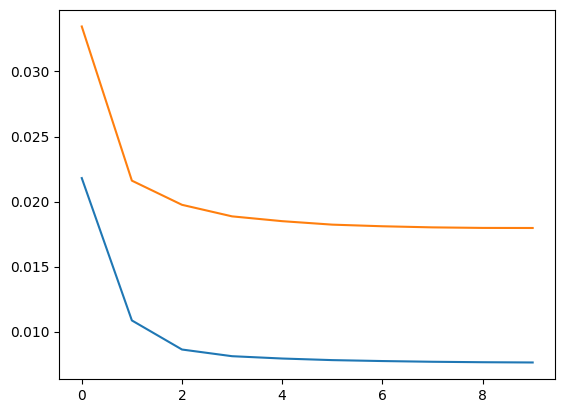

In [139]:
plt.plot(train_history)
plt.plot(valid_history)

In [145]:
X_pred = []
embeddings = []
for data in data_loader:
    x_pred = model(data[0])
    emb = model.encoder(data[0])
    X_pred.append(x_pred.detach().numpy())
    embeddings.append(emb.detach().numpy())

X_pred = np.concatenate(X_pred,axis=0)
embeddings= np.concatenate(embeddings,axis=0)

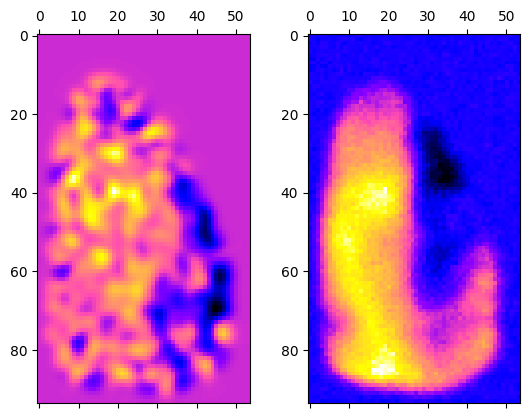

In [152]:
example = 9

fig,ax= plt.subplots(1,2)
ax[0].matshow(X[example,0,:],cmap=plt.cm.gnuplot2)
ax[1].matshow(X_pred[example,0,:],cmap=plt.cm.gnuplot2)

In [14]:
max_imgs = find_max_activation_images(model,10,img_shape = X.shape[1:])

In [15]:
max_imgs.shape

(10, 94, 53)

# Clamped features

In [140]:
model = torch.load(MODEL_PATH.joinpath('model1'))

In [141]:
def get_clamped_modes(model):

    input = torch.eye(model.latent_dim)
    imgs = model.decoder(input)
    imgs = imgs.detach().numpy()
    imgs  = imgs[:,0,:,:]

    return imgs

def plot_latent_modes(imgs,mask):

    fig,ax = plt.subplots(1,len(imgs),figsize=(5*len(imgs),5))
    for i, img in enumerate(imgs):
        plot_img = img.copy()
        plot_img[mask[:,:-1] == 0] = np.nan
        ax[i].imshow(plot_img,cmap=plt.cm.gnuplot2)
        ax[i].axis('off')
    
    plt.tight_layout()

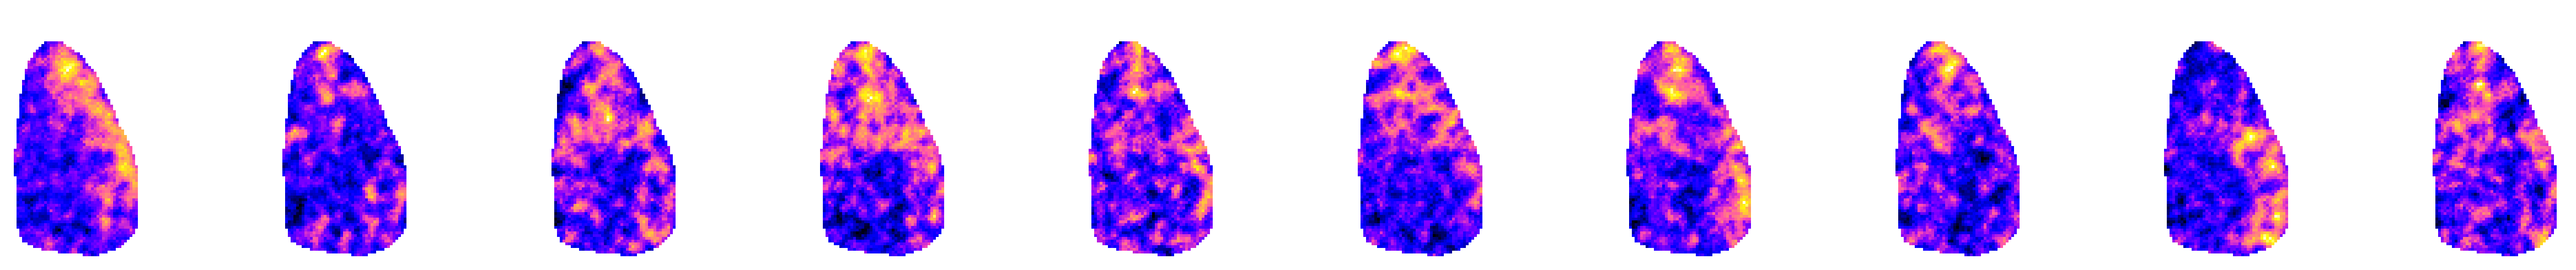

In [142]:
plot_latent_modes(imgs,mask)